In [1]:
#####################################################################################################
# This notebook contains example code for reading, visualizing and working with the alignment data. #
# You can reuse the code and expand on it for your own needs.                                       #
#####################################################################################################

#### Log Moves

Here the algorithm makes the trace move a step while the model remains in the current position. So the model does 


In [2]:
#pip install pm4py

In [3]:
#Imports
from mira.prelim.poset import POSet
from mira.nets.firing import NuFiring
from mira.nets.transition import Transition
from mira.nets.marking import NuMarking
from mira.prelim.colors import Color

import numpy as np
import json

import re
import pandas as pd

import os
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2, chi2_contingency

In [4]:
# Read dataframe
df = pd.read_csv('C:/Users/20203721/OneDrive - TU Eindhoven/Documents/BEP/data/alignments/dataframe - Blad1.csv', header=0)
df

,action,user,case_nr,move_type
0,A:START,c100,User_1,log
1,A:COMPLETE,c100,User_1,log
2,B:START,c100,User_1,log
3,B:COMPLETE,c100,User_1,log
4,A:START,c101,User_1,log
...,...,...,...,...
389,E:COMPLETE,c196,User_1,model
390,A:START,c196,User_1,log
391,A:COMPLETE,c196,User_1,log
392,B:START,c196,User_1,log


In [5]:
# Create a mask to identify rows where 'user' and 'case_nr' are swapped
mask = (df['user'].str.startswith('User_') & df['case_nr'].str.startswith('c'))

# Swap 'user' and 'case_nr' for the rows identified by the mask
df.loc[mask, ['user', 'case_nr']] = df.loc[mask, ['case_nr', 'user']].values

# Rename columns
df.rename(columns={"user": "case_nr", "case_nr": "user"}, inplace=True)

In [6]:
# Filter rows with move_type equal to "log"
log_df = df

# Identify consecutive rows using the default integer index
consecutive_rows = log_df.index.to_series().diff() == 1

# Identify cases where there are at least 2 consecutive actions
cases_with_consecutive_actions = consecutive_rows.groupby(log_df['case_nr']).transform('sum') > 2

# Select rows where there are at least 2 consecutive actions for the same case
result_df = log_df[cases_with_consecutive_actions]

# Display the resulting DataFrame
result_df

,action,case_nr,user,move_type
0,A:START,c100,User_1,log
1,A:COMPLETE,c100,User_1,log
2,B:START,c100,User_1,log
3,B:COMPLETE,c100,User_1,log
4,A:START,c101,User_1,log
...,...,...,...,...
389,E:COMPLETE,c196,User_1,model
390,A:START,c196,User_1,log
391,A:COMPLETE,c196,User_1,log
392,B:START,c196,User_1,log


In [7]:
# Check if all cases have more than 2 observations
# When this is true, the outut of this is the length of the series printed below.
result_df['case_nr'].nunique()

97

In [8]:
at_least_2 = result_df.groupby('case_nr').size() > 2
print(at_least_2[at_least_2])

case_nr
c100    True
c101    True
c102    True
c103    True
c104    True
        ... 
c192    True
c193    True
c194    True
c195    True
c196    True
Length: 97, dtype: bool


In [9]:
# Get next log move using shift
result_df['next_event'] = result_df.groupby('case_nr')['action'].shift(-2)
result_df['next_event_type'] = result_df.groupby('case_nr')['move_type'].shift(-2)

result_df.tail(10)

,action,case_nr,user,move_type,next_event,next_event_type
384,A:START,c196,User_1,log,B:START,log
385,A:COMPLETE,c196,User_1,log,B:COMPLETE,log
386,B:START,c196,User_1,log,E:START,model
387,B:COMPLETE,c196,User_1,log,E:COMPLETE,model
388,E:START,c196,User_1,model,A:START,log
389,E:COMPLETE,c196,User_1,model,A:COMPLETE,log
390,A:START,c196,User_1,log,B:START,log
391,A:COMPLETE,c196,User_1,log,B:COMPLETE,log
392,B:START,c196,User_1,log,NaN,NaN
393,B:COMPLETE,c196,User_1,log,NaN,NaN


In [10]:
# Drop :COMPLETE observations, thereby halving the dataset. Possible because it's not needed for this research
result_df = result_df[~result_df['action'].str.endswith(':COMPLETE')]
result_df['action'] = result_df['action'].str.replace(':START', '')
result_df['next_event'] = result_df['next_event'].str.replace(':START', '')


result_df

C:\Users\20203721\AppData\Local\Temp\ipykernel_32876\807926713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['action'] = result_df['action'].str.replace(':START', '')
C:\Users\20203721\AppData\Local\Temp\ipykernel_32876\807926713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['next_event'] = result_df['next_event'].str.replace(':START', '')


,action,case_nr,user,move_type,next_event,next_event_type
0,A,c100,User_1,log,B,log
2,B,c100,User_1,log,NaN,NaN
4,A,c101,User_1,log,C,log
6,C,c101,User_1,log,NaN,NaN
8,A,c102,User_1,log,D,log
...,...,...,...,...,...,...
384,A,c196,User_1,log,B,log
386,B,c196,User_1,log,E,model
388,E,c196,User_1,model,A,log
390,A,c196,User_1,log,B,log


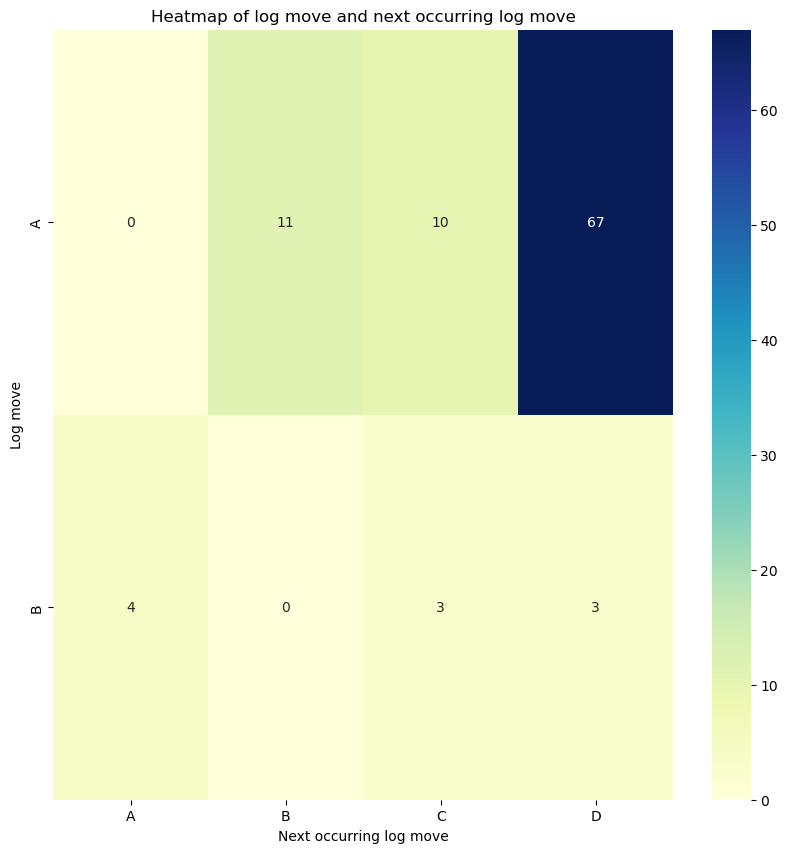

In [11]:
# Create a heatmap
heatmap_data = result_df[(result_df['move_type'] == 'log') & (result_df['next_event_type'] == 'log')].pivot_table(index='action', columns='next_event', aggfunc='size', fill_value=0)

plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Heatmap of log move and next occurring log move')
plt.xlabel('Next occurring log move')
plt.ylabel('Log move')
plt.show()

In [12]:
heatmap_data

next_event,A,B,C,D
action,,,,
A,0,11,10,67
B,4,0,3,3


In [13]:
row_results = pd.DataFrame(columns=['Action', 'Max', 'Next Event', 'Sum of row'])

# Loop over each row and find the maximum number and its label
for index, row in heatmap_data.iterrows():
    action = index
    max_row_value = row.max()
    next_event = row.idxmax()
    sum_row = row.sum()
 
    new_row = pd.DataFrame({'Action': [action], 'Max': [max_row_value], 'Next Event': [next_event], 'Sum of row': [sum_row]})
    row_results = pd.concat([row_results, new_row], ignore_index=True)
    
row_results

,Action,Max,Next Event,Sum of row
0,A,67,D,88
1,B,4,A,10


In [14]:
column_results = pd.DataFrame(columns=['Next Event', 'Sum of column'])

# Loop over each row and find the maximum number and its label
for index, column in heatmap_data.items():
    sum_col = column.values.sum()
 
    new_row = pd.DataFrame({'Next Event': [index], 'Sum of column': [sum_col]})
    column_results = pd.concat([column_results, new_row], ignore_index=True)
    
column_results

,Next Event,Sum of column
0,A,4
1,B,11
2,C,13
3,D,70


In [15]:
indep_outcomes = pd.DataFrame(columns=['Event', 'Next Event', 'Yes/Yes', 'Yes/No', 'No/Yes', 'No/No'])

column_result_dict = column_results.set_index('Next Event')['Sum of column'].to_dict()

total = row_results['Sum of row'].sum()

for index, row in row_results.iterrows():
    yes_yes = row['Max']
    yes_no = row['Sum of row'] - row['Max']
    no_yes = (column_result_dict.get(row['Next Event'], 0)) - row['Max']
    #no_no = total - column_result_dict.get(row['Next Event'], 0)
    no_no = total - yes_yes - yes_no - no_yes
    
    new_row = pd.DataFrame({'Event': row['Action'], 'Next Event': row['Next Event'], 'Yes/Yes': yes_yes,
                            'Yes/No': yes_no , 'No/Yes': no_yes, 'No/No': no_no}, index=[0])
    indep_outcomes = pd.concat([indep_outcomes, new_row], ignore_index=True)
    
indep_outcomes

,Event,Next Event,Yes/Yes,Yes/No,No/Yes,No/No
0,A,D,67,21,3,7
1,B,A,4,6,0,88


# Chi-square test by hand

Steps: <br>
    1. Have contingency table<br>
    2. Calculate the chi-squared statistic<br>
          Chi-square = $Σ [(Oij - Eij)² / Eij]$<br>
          $Oij$: Observed count in cell (i, j)<br>
          $Eij$: Expected count in cell (i, j)<br>
          The expected count $Eij$ is calculated based on the assumption of independence, which is given by:<br>
            $Eij$ = (Row i's total count * Column j's total count) / Grand Total <br>
    3. Determine degrees of freedom (df)<br>
        The degrees of freedom for a chi-squared test for independence can be calculated as df = (R - 1) * (C - 1), where R is the number of rows and C is the number of columns in the contingency table <br>
    4. Find the critical value using the Chi-square distribution table <br>
    5. Calculate the Chi-square value
    6. Reject Null-hypothesis when Chi_square $\ge$ critical value
          

In [16]:
# Sum of Yes/Yes, Yes/No and No/Yes must be above the defined threshold

threshold = 50
indep_outcomes = indep_outcomes[indep_outcomes.iloc[:, -4:-2].sum(axis=1) > threshold]

indep_outcomes = indep_outcomes.reset_index(drop=True)
indep_outcomes

,Event,Next Event,Yes/Yes,Yes/No,No/Yes,No/No
0,A,D,67,21,3,7


In [17]:
# For each pair, calculate all expected outcomes

indep_outcomes['exp_yes/yes'] = ((indep_outcomes['Yes/Yes'] + indep_outcomes['No/Yes']) * (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No']))/ (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No'] + indep_outcomes['No/Yes'] + indep_outcomes['No/No'])
indep_outcomes['exp_yes/no'] = ((indep_outcomes['Yes/No'] + indep_outcomes['No/No']) * (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No']))/ (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No'] + indep_outcomes['No/Yes'] + indep_outcomes['No/No'])
indep_outcomes['exp_no/yes'] = ((indep_outcomes['Yes/Yes'] + indep_outcomes['No/Yes']) * (indep_outcomes['No/Yes'] + indep_outcomes['No/No']))/ (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No'] + indep_outcomes['No/Yes'] + indep_outcomes['No/No'])
indep_outcomes['exp_no/no'] = ((indep_outcomes['Yes/No'] + indep_outcomes['No/No']) * (indep_outcomes['No/Yes'] + indep_outcomes['No/No']))/ (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No'] + indep_outcomes['No/Yes'] + indep_outcomes['No/No'])

# Calculate Chi-square value
indep_outcomes['Chi_sqrt'] = ((((indep_outcomes['Yes/Yes']-indep_outcomes['exp_yes/yes'])**2)/indep_outcomes['exp_yes/yes']) +
                              (((indep_outcomes['Yes/No']-indep_outcomes['exp_yes/no'])**2)/indep_outcomes['exp_yes/no']) +
                              (((indep_outcomes['No/Yes']-indep_outcomes['exp_no/yes'])**2)/indep_outcomes['exp_no/yes']) +
                              (((indep_outcomes['No/No']-indep_outcomes['exp_no/no'])**2)/indep_outcomes['exp_no/no']))

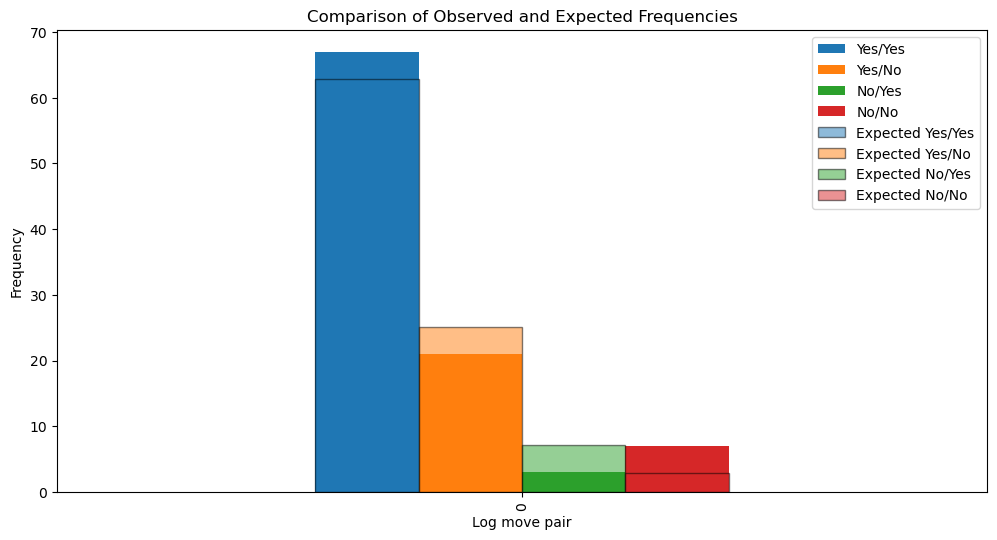

In [18]:
# Comparing the observed and expected freqencies
observed_cols = ['Yes/Yes', 'Yes/No', 'No/Yes', 'No/No']
expected_cols = ['exp_yes/yes', 'exp_yes/no', 'exp_no/yes', 'exp_no/no']

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
indep_outcomes[observed_cols].plot(kind='bar',  ax=ax, width=0.4)
indep_outcomes[expected_cols].plot(kind='bar',  ax=ax, width=0.4, alpha=0.5, edgecolor='black')

plt.title('Comparison of Observed and Expected Frequencies')
plt.xlabel('Log move pair')
plt.ylabel('Frequency')
plt.legend(['Yes/Yes', 'Yes/No', 'No/Yes', 'No/No', 'Expected Yes/Yes', 'Expected Yes/No', 'Expected No/Yes', 'Expected No/No'])
plt.show()

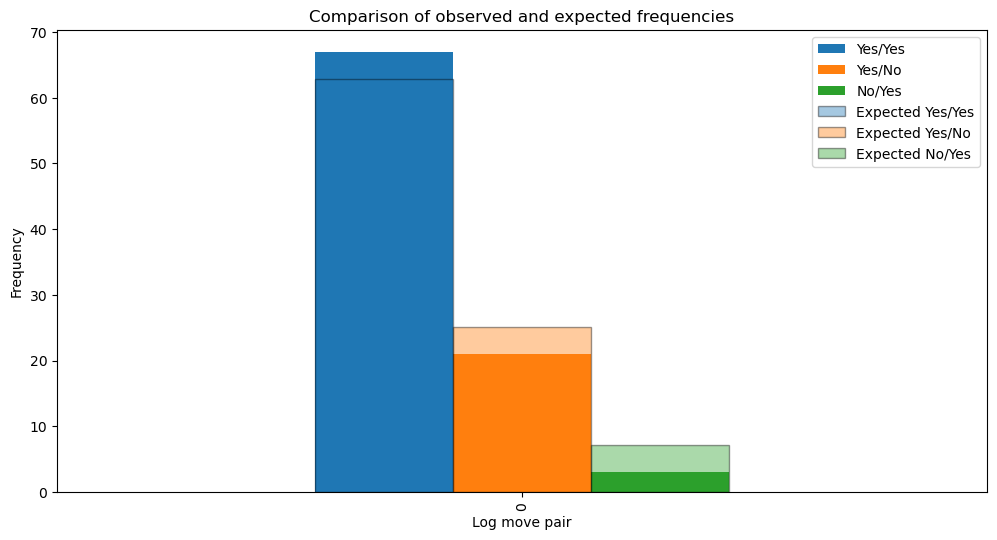

In [19]:
# Comparing the observed and expected freqencies leaving out the No/No pairs
observed_cols = ['Yes/Yes', 'Yes/No', 'No/Yes']
expected_cols = ['exp_yes/yes', 'exp_yes/no', 'exp_no/yes']

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
indep_outcomes[observed_cols].plot(kind='bar', ax=ax, width=0.4)
indep_outcomes[expected_cols].plot(kind='bar', ax=ax, width=0.4, alpha=0.4, edgecolor='black')

plt.title('Comparison of observed and expected frequencies')
plt.xlabel('Log move pair')
plt.ylabel('Frequency')
plt.legend(['Yes/Yes', 'Yes/No', 'No/Yes', 'Expected Yes/Yes', 'Expected Yes/No', 'Expected No/Yes'])
plt.show()

In [20]:
# Critical value from the chi-square distribution table
critical_value = 3.841

reject_pairs = []
accept_pairs = []

# Check if the Chi-square values are larger than the critical value,
# if so, append to the rejected pairs list, otherwise append to the accepted pairs list.
for index, row in indep_outcomes.iterrows():
    if row['Chi_sqrt'] > critical_value:
        reject_pairs.append((row['Event'], row['Next Event'], "Chi-square value: " + str(round(row['Chi_sqrt'], 2))))
    else:
        accept_pairs.append((row['Event'], row['Next Event'], "Chi-square value: " + str(round(row['Chi_sqrt'], 2))))

        
print("Accept the null hypothesis for the following pairs of events:")
for pair in accept_pairs:
    print(pair)  
        
print("\nReject the null hypothesis for the following pairs of events:")
for pair in reject_pairs:
    print(pair)

Accept the null hypothesis for the following pairs of events:

Reject the null hypothesis for the following pairs of events:
('A', 'D', 'Chi-square value: 9.37')


# Chi-square test for independence using scipy.stats

Null Hypothesis: There is no relation between log move A and log move B.<br>
Alternative Hypothesis: There is a relation between log move A and log move B.

In [21]:
# Chi-square test using the scipy.stats module.

#It gives different values for the Chi-square values, 
# eventhough the expected frequencies are in accordance with the expected freqencies calculated by hand.
for index, row in indep_outcomes.iterrows():
    observed_data = [
    [row["Yes/Yes"], row["Yes/No"]],
    [row["No/Yes"], row["No/No"]]]
    
    chi2_stat, p_value, dof, expected = chi2_contingency(observed_data)

    print(f"Chi square Stat: {chi2_stat}")
    print(f"P-value: {p_value}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected table:")
    print(observed_data)
    print(expected)
    print()

Chi square Stat: 7.241420454545454
P-value: 0.007124059710157145
Degrees of Freedom: 1
Expected table:
[[67, 21], [3, 7]]
[[62.85714286 25.14285714]
 [ 7.14285714  2.85714286]]



In [22]:
# all p values are below 0.05 reject null hypothesis. So, there is a relation between Event A and event B